In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

In [3]:

filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
type(final)

pandas.core.frame.DataFrame

In [12]:
positive_reviews = final.loc[final['Score'] == 'positive']

In [13]:
positive_reviews.shape

(307061, 10)

In [14]:
negative_reviews = final.loc[final['Score'] == 'negative']

In [15]:
negative_reviews.shape

(57110, 10)

In [16]:
positive_rev_sample = positive_reviews.sample(n=2000)

In [17]:
positive_rev_sample.shape

(2000, 10)

In [18]:
negative_rev_sample = negative_reviews.sample(n=2000)

In [19]:
negative_rev_sample.shape

(2000, 10)

In [20]:
sample_reviews = positive_rev_sample.append(negative_rev_sample,ignore_index=True)

In [21]:
sample_reviews.shape

(4000, 10)

In [22]:
sample_reviews['Score'].value_counts()

negative    2000
positive    2000
Name: Score, dtype: int64

In [23]:
scores = sample_reviews['Score']

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/murali.radix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"it's", 'which', 'do', 'are', 'aren', "hasn't", 'and', 'against', 'herself', 'wouldn', 'to', 'such', 'some', 'whom', "wasn't", "wouldn't", 'at', 'again', 'hadn', 'on', 'myself', "you'll", 'their', 'if', 'm', 'mightn', 'itself', 'yourself', 'but', 'other', 'a', 'in', 'shouldn', 'into', "hadn't", 'over', "aren't", 'too', 'the', 'ain', 'he', 'where', "doesn't", 't', 'isn', 'until', 'same', 'when', 'yours', 'there', 'have', 'they', "couldn't", "mightn't", 'ourselves', 'of', 'o', 'y', "that'll", 'being', 'not', 'ours', 'll', 'hers', 'while', 'shan', 'doing', 'be', 'or', 'after', 're', 'through', 'up', 'we', 'couldn', 'once', 'down', 'below', "you'd", 'didn', "you've", 'don', 'just', 'been', 'no', 'that', 'so', 'yourselves', 'than', 'me', 'an', 'what', 'as', "needn't", 'mustn', 'it', 'few', "shouldn't", 'had', 'from', 'more', 'd', "haven't", 'weren', "didn't", 'off', 'all', 'only', 'theirs', 'our', 'now', 'themselves', 'its', 'ma', 'his', 'having', 'these', 'will', 've', 'nor', 'those', 've

In [26]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sample_reviews['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [27]:
sample_reviews['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [28]:
sample_reviews.shape

(4000, 11)

In [29]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
sample_reviews.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sample_reviews['Text'].values)

In [31]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [32]:
final_counts.get_shape()

(4000, 13617)

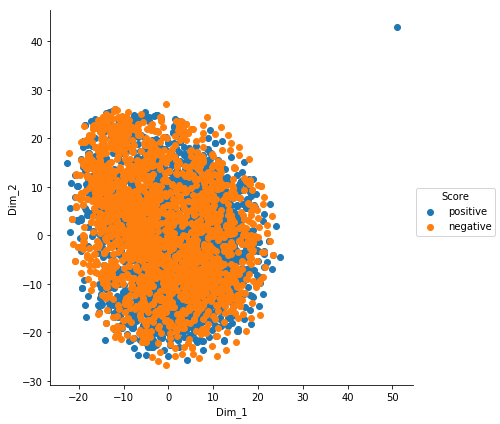

In [33]:
from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_counts.toarray()) 
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

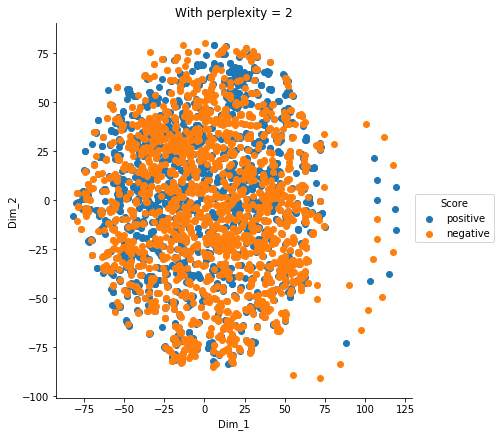

In [34]:
model = TSNE(n_components=2, random_state=0,perplexity=2)
tsne_data = model.fit_transform(final_counts.toarray()) 
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 2')
plt.show()

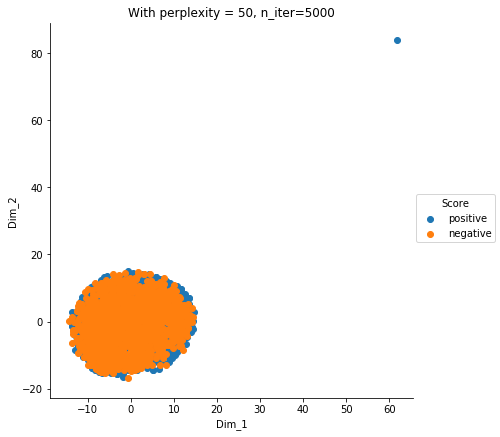

In [35]:
model = TSNE(n_components=2, random_state=0,perplexity=50,  n_iter=5000)
tsne_data = model.fit_transform(final_counts.toarray()) 
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()

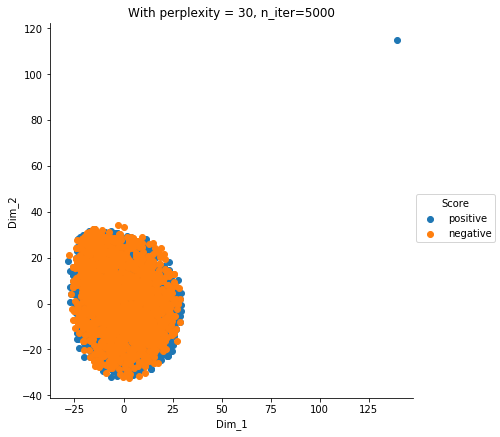

In [36]:
model = TSNE(n_components=2, random_state=0,perplexity=30,  n_iter=5000)
tsne_data = model.fit_transform(final_counts.toarray()) 
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30, n_iter=5000')
plt.show()

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(sample_reviews['Text'].values)


In [38]:
final_bigram_counts.get_shape()

(4000, 141382)

# TF-IDF

In [39]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sample_reviews['Text'].values)

In [40]:
final_tf_idf.get_shape()
type(final_tf_idf)

scipy.sparse.csr.csr_matrix

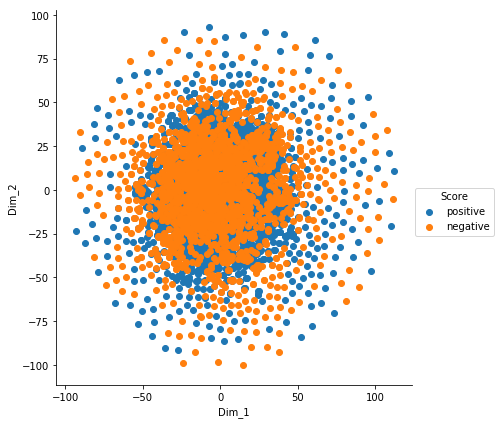

In [58]:
from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot as plt
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_tf_idf.toarray()) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

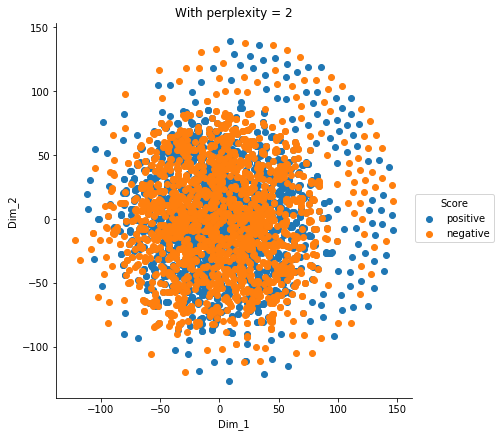

In [60]:
model = TSNE(n_components=2, random_state=0,perplexity=2)
tsne_data = model.fit_transform(final_tf_idf.toarray()) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 2')
plt.show()

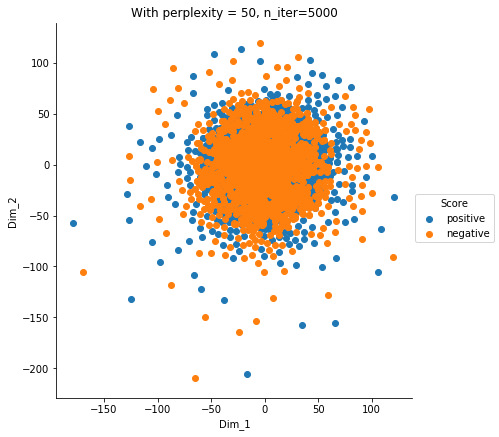

In [61]:
model = TSNE(n_components=2, random_state=0,perplexity=50,  n_iter=5000)
tsne_data = model.fit_transform(final_tf_idf.toarray()) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()

# Word2Vec

In [41]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in sample_reviews['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [42]:
print(sample_reviews['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])
print(len(list_of_sent))

I like to baste this heavily over pork roast and serve extra on the side.  My family LOVES it!
*****************************************************************
['i', 'like', 'to', 'baste', 'this', 'heavily', 'over', 'pork', 'roast', 'and', 'serve', 'extra', 'on', 'the', 'side', 'my', 'family', 'loves', 'it']
4000


In [43]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=1,size=50, workers=4)    


In [44]:
words = list(w2v_model.wv.vocab)
print(len(words))

3841


In [45]:
w2v_model.wv.most_similar('tasty')

[('salty', 0.9887638092041016),
 ('healthy', 0.9840006828308105),
 ('yummy', 0.9834398627281189),
 ('packaged', 0.982458233833313),
 ('spicy', 0.9822670221328735),
 ('fresh', 0.9820382595062256),
 ('differ', 0.9812339544296265),
 ('delicious', 0.9800727963447571),
 ('satisfying', 0.9788355827331543),
 ('moist', 0.9786685705184937)]

# Avg W2V

In [46]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


In [47]:
avgW2V = np.asarray(sent_vectors)
print(avgW2V.shape)

(4000, 50)


In [48]:
print(scores.shape)
print(avgW2V.shape)

(4000,)
(4000, 50)


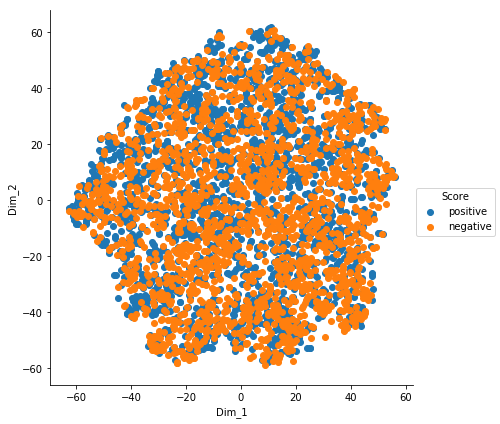

In [49]:
from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot as plt
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(avgW2V) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

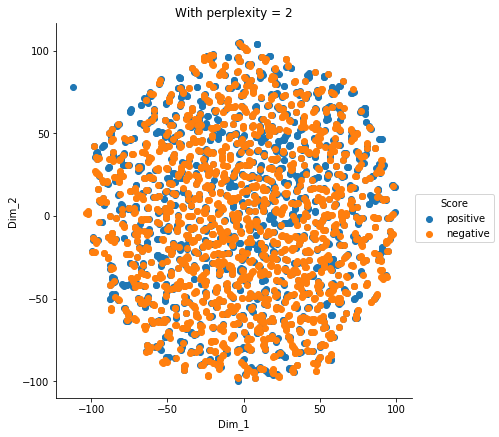

In [50]:
model = TSNE(n_components=2, random_state=0,perplexity=2)
tsne_data = model.fit_transform(avgW2V) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 2')
plt.show()

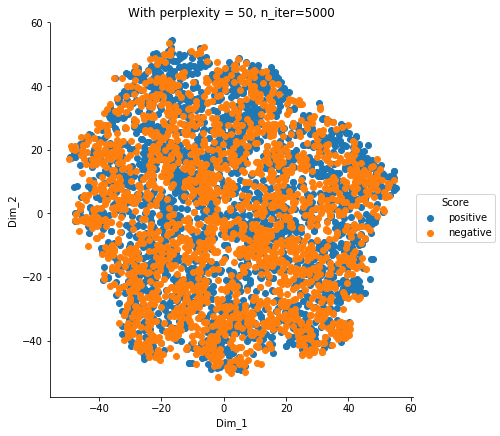

In [51]:
model = TSNE(n_components=2, random_state=0,perplexity=50,  n_iter=5000)
tsne_data = model.fit_transform(avgW2V) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, scores)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()